In [8]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

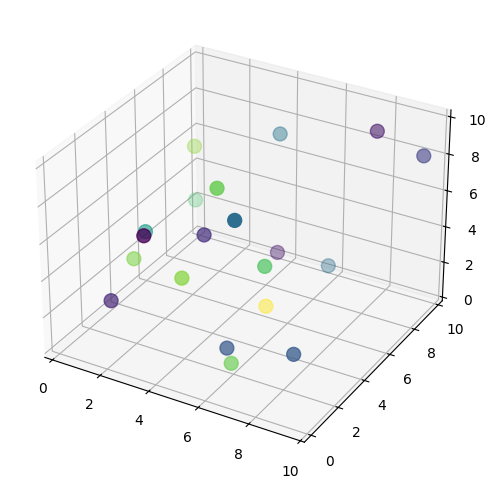

In [9]:
# Number of points
num_points = 20

# Generate random 3D points
np.random.seed(42)
points = np.random.rand(num_points, 3) * 10 # Random points in [0,10]³

# Assign random "energy" values
energies = np.random.rand(num_points)

# Compute the distance matrix between points
dist_matrix = distance_matrix(points, points)

# Define a critical radius for neighborhood search
critical_radius = 4.0

# Display dataset
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c=energies, cmap="viridis", s=100)
plt.show()


In [10]:
num_qubits = int(np.ceil(np.log2(num_points)))  # Compute required number of qubits

dev = qml.device("default.qubit", wires=num_qubits+1, shots=1)  # Initialize Pennylane device
wires = list(range(num_qubits))

In [11]:
def Oracle_Simple(index,comp_point,wires, crit_dist, ans_set):
    
    # Oracle: Flip amplitude if distance condition is met
    print((dist_matrix[index,comp_point] < crit_dist).any() and index not in ans_set)
    if (dist_matrix[index, comp_point] < crit_dist).any() and (index not in ans_set):
        for value in dist_matrix[index, comp_point] < crit_dist:
            b_str = bin(value)[2:].zfill(num_qubits)
            for m in b_str:
                qml.MultiControlledX(wires, num_qubits, m)

@qml.qnode(dev)        
def Grover_Local_Dense(wires, index, comp_point, crit_dist,niter, ans_set):
    # Convert index to binary array and ensure it matches available qubits
    bin_state = np.array(list(np.binary_repr(index, width=num_qubits)), dtype=int)[:num_qubits]
    
    #Hadamard layer
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)

    #Phase Kickback
    qml.PauliX(num_qubits)
    qml.Hadamard(num_qubits)

    #Grover Loop
    for iter in range(niter):
        Oracle_Simple(index,wires,comp_point,crit_dist, ans_set)
        qml.templates.GroverOperator(wires=wires)
    
    return [qml.sample(qml.PauliZ(i)) for i in wires] 

def local_density_circuit_revamp(index,crit_dist):
    #placeholder for iterations required
    niter = 1
    local_dense_mat = []

    #loop through all points and run grover 10 times to find all points within critical radius to the point 'index'
    for i in range(20):
        for m in range(10):
            candidate = np.real(Grover_Local_Dense(wires,index,i,crit_dist,niter, local_dense_mat))
            if candidate not in local_dense_mat:
                local_dense_mat.append(candidate)
    
    return local_dense_mat

In [12]:
ans = []
print(np.real(Grover_Local_Dense(wires,2,2,5,2,ans)))
local_mat = local_density_circuit_revamp(2,2)

True
True
[ 1. -1.  1. -1. -1.]
True


/var/folders/8l/ycc5vbn93_56mddr52w8zp040000gn/T/ipykernel_16769/3329384450.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  b_str = bin(value)[2:].zfill(num_qubits)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
@qml.qnode(dev)
def local_density_circuit(index):
    """Quantum circuit to check if a point has neighbors within critical_radius"""

    # Convert index to binary array and ensure it matches available qubits
    bin_state = np.array(list(np.binary_repr(index, width=num_qubits)), dtype=int)[:num_qubits]

    qml.BasisState(bin_state, wires=range(num_qubits))

    # Apply Hadamard gates individually
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)

    # Oracle: Flip amplitude if distance condition is met
    for i in range(num_points):
        if dist_matrix[index, i] < critical_radius:
            qml.PauliX(wires=i % num_qubits)  # Ensure valid wire indexing

    # Grover diffusion step
    for wire in range(num_qubits):  
        qml.Hadamard(wires=wire)

    if num_qubits > 1:
        qml.MultiControlledX(
            wires=list(range(num_qubits - 1)) + [num_qubits - 1],
            control_values="1" * (num_qubits - 1)
        )

    for wire in range(num_qubits):  
        qml.Hadamard(wires=wire)

    return qml.probs(wires=range(num_qubits))


In [ ]:
densities = np.array([
    energies[i] + 0.5 * np.sum(energies[dist_matrix[i] < critical_radius]) 
    for i in range(num_points)
])

In [ ]:
@qml.qnode(dev)
def nearest_higher_circuit(index, densities, dist_matrix, critical_radius):
    """Quantum circuit to find nearest higher-density point using Grover's search"""

    bin_state = np.array(list(np.binary_repr(index, width=num_qubits)), dtype=int)[:num_qubits]

    qml.BasisState(bin_state, wires=range(num_qubits))

    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)

    # Oracle: Flip amplitude if density condition is met
    for i in range(num_points):
        if densities[i] > densities[index] and dist_matrix[index, i] < critical_radius:
            qml.PauliX(wires=i % num_qubits)

    # Grover diffusion step
    for wire in range(num_qubits):  
        qml.Hadamard(wires=wire)

    if num_qubits > 1:
        qml.MultiControlledX(
            wires=list(range(num_qubits - 1)) + [num_qubits - 1],
            control_values="1" * (num_qubits - 1)
        )

    for wire in range(num_qubits):  
        qml.Hadamard(wires=wire)

    return qml.probs(wires=range(num_qubits))


In [ ]:
nearest_higher = np.array([
    min(
        (j for j in range(num_points) if densities[j] > densities[i] and dist_matrix[i, j] < critical_radius),
        key=lambda j: dist_matrix[i, j],
        default=i
    )
    for i in range(num_points)
])

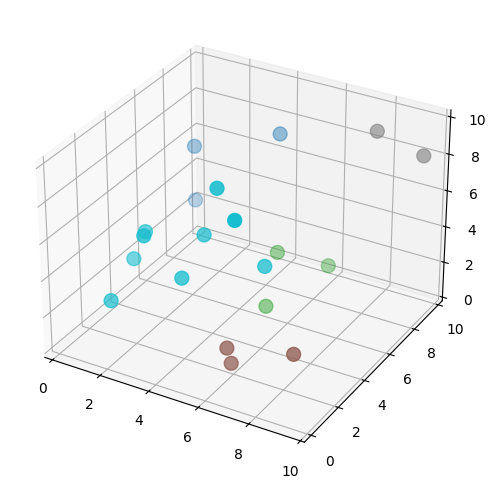

In [ ]:
clusters = np.full(num_points, -1)
current_cluster = 0

# Identify cluster seeds (points with no higher-density neighbor)
for i in range(num_points):
    if nearest_higher[i] == i:  # Seed points
        clusters[i] = current_cluster
        current_cluster += 1

# Assign clusters to remaining points
for i in range(num_points):
    if clusters[i] == -1:  # Not assigned yet
        neighbor = nearest_higher[i]
        while clusters[neighbor] == -1:  # Follow density hierarchy
            neighbor = nearest_higher[neighbor]
        clusters[i] = clusters[neighbor]  # Assign to nearest cluster

# Visualize Clusters
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(points[:,0], points[:,1], points[:,2], c=clusters, cmap="tab10", s=100)
plt.show()


In [ ]:
print("Densities:", densities)
print("Nearest Higher:", nearest_higher)
print("Clusters:", clusters)

Densities: [0.99738469 1.3413439  1.79087358 0.92076516 1.30770225 1.75403103
 2.0444634  2.01077087 0.7845023  1.69683859 1.43450892 0.33509585
 1.20139375 2.52697448 1.47465477 1.71217083 1.40850535 0.21042482
 1.06841738 1.25674189]
Nearest Higher: [ 2 10  2 16  1  7 13 13 18  9 10 11 13 13  2  6  6 11  9  7]
Clusters: [0 2 0 4 2 4 4 4 1 1 2 3 4 4 0 4 4 3 1 4]


In [ ]:
num_qubits = 3  # Adjust based on dataset
dev = qml.device("default.qubit", wires=2*num_qubits + 1)

@qml.qnode(dev)
def quantum_swap_test(theta1, theta2):
    """Quantum circuit to compute similarity (distance) using the swap test."""

    # Control qubit
    qml.Hadamard(wires=0)

    # Encode first point into wires 1 to num_qubits
    for i in range(num_qubits):
        qml.RY(theta1[i], wires=i+1)
    
    # Encode second point into **different wires** (num_qubits+1 to 2*num_qubits)
    for i in range(num_qubits):
        qml.RY(theta2[i], wires=num_qubits + i + 1)
    
    # Controlled swap operation between corresponding qubits
    for i in range(num_qubits):
        qml.CSWAP(wires=[0, i+1, num_qubits+1 + i])

    # Hadamard on control qubit
    qml.Hadamard(wires=0)

    # Measure the probability of |0⟩ (related to distance)
    return qml.probs(wires=[0])

def quantum_distance(p1, p2):
    """Computes quantum distance using the swap test."""
    theta1 = np.arcsin(p1 / np.linalg.norm(p1))
    theta2 = np.arcsin(p2 / np.linalg.norm(p2))
    
    prob_0 = quantum_swap_test(theta1, theta2)[0]  # Probability of measuring |0⟩
    return 1 - 2 * prob_0  # Convert to a distance metric


In [ ]:
# Define number of clusters (K)
num_clusters = 3

# Initialize centroids randomly
centroids = points[np.random.choice(num_points, num_clusters, replace=False)]

def assign_clusters(points, centroids):
    """Assign each point to the nearest centroid based on quantum distance."""
    assignments = np.zeros(len(points), dtype=int)
    for i, point in enumerate(points):
        distances = np.array([quantum_distance(point, centroid) for centroid in centroids])
        assignments[i] = np.argmin(distances)  # Assign to the nearest centroid
    return assignments

def update_centroids(points, assignments, num_clusters):
    """Recompute centroids based on cluster assignments."""
    new_centroids = np.array([
        np.mean(points[assignments == k], axis=0) if np.any(assignments == k) else points[np.random.choice(len(points))]
        for k in range(num_clusters)
    ])
    return new_centroids

# Run Quantum K-Means
max_iterations = 10
tolerance = 1e-4

for iteration in range(max_iterations):
    prev_centroids = centroids.copy()
    
    # Step 1: Assign points to the nearest centroid
    assignments = assign_clusters(points, centroids)
    
    # Step 2: Update centroids
    centroids = update_centroids(points, assignments, num_clusters)
    
    # Step 3: Check for convergence
    if np.linalg.norm(centroids - prev_centroids) < tolerance:
        print(f"Converged at iteration {iteration}")
        break


Converged at iteration 6


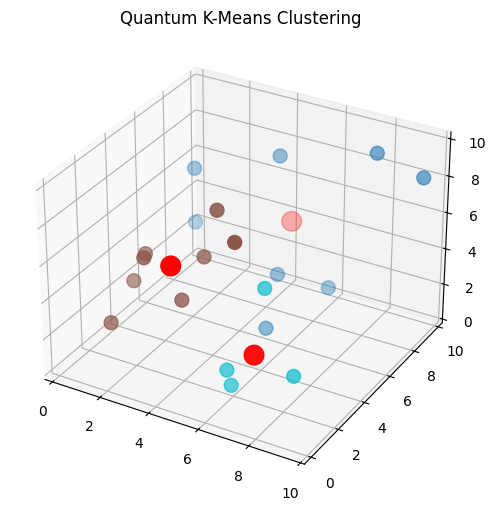

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# Plot clusters
scatter = ax.scatter(points[:,0], points[:,1], points[:,2], c=assignments, cmap="tab10", s=100)
# Plot centroids
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], c="red", s=200, marker="o")

plt.title("Quantum K-Means Clustering")
plt.show()
